# Quantum Key Distribution (BB84) Simulation with Cascade Error Correction

This document provides a detailed, step-by-step explanation of a Python simulation for the BB84 Quantum Key Distribution (QKD) protocol. The simulation includes actors for Alice, Bob, and Eve, simulates a quantum channel with noise and attenuation, and implements the Cascade protocol for error correction.

## 1. Imports and Configuration

The simulation relies on Python's `asyncio` for simulating the asynchronous nature of network communication (sending photons and messages). It also uses `dataclasses` for structured data and `matplotlib` for generating performance graphs.

In [1]:
import asyncio
import random
import logging
import datetime
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass
from enum import Enum
from typing import Optional, List, Dict, Tuple, Any
from abc import ABC, abstractmethod

# --- Logging Configuration ---
logging.basicConfig(level=logging.ERROR, format='%(message)s')

## 2. Primitives and Data Structures

We define the fundamental building blocks of the physics simulation.

*   **`Basis`**: An Enum representing the two measurement bases used in BB84: Rectilinear ($+$) and Diagonal ($\times$).
*   **`Photon`**: Represents a "qubit" traveling through the fiber. It carries a bit value (0 or 1), the basis it was encoded in, and physical properties like wavelength (for realism, though not used in logic).
*   **`DetectionEvent`**: The result of a detector "clicking." It records what basis Bob used, what bit was measured, and whether it was a signal or a dark count (noise).

In [2]:
# --- Primitives ---

class Basis(Enum):
    RECTILINEAR = "+" 
    DIAGONAL = "x"   

@dataclass
class Photon:
    id: int
    bit: int
    basis: Basis
    creation_time: str
    wavelength_nm: float = 1550.0

@dataclass
class DetectionEvent:
    photon_id: int
    basis: Basis
    bit: int
    detection_time: str
    source: str 

## 3. Central Random Number Generator

In cryptographic simulations, controlling randomness is crucial for reproducibility. This Singleton class wraps `random` to ensure that if we set a seed, the entire simulation (Alice's choices, channel errors, detection probabilities) behaves deterministically.

In [3]:
# --- CENTRAL PRNG CLASS ---

class PRNG:
    _instance = None
    def __new__(cls):
        if cls._instance is None:
            cls._instance = super(PRNG, cls).__new__(cls)
        return cls._instance

    def seed(self, val):
        random.seed(val)

    def get_bit(self) -> int: return random.choice([0, 1])
    def get_basis(self) -> Basis: return random.choice(list(Basis))
    def random(self) -> float: return random.random()
    def shuffle(self, x: list): random.shuffle(x)
    def choice(self, options: list): return random.choice(options)

prng = PRNG()

## 4. Helper Utilities

This utility function prints a visual comparison of Alice's key vs. Bob's key before and after error correction. It helps visualize bit flips (errors) and whether the correction algorithm fixed them.

In [4]:
# --- HELPER: Table Printer ---

def print_key_comparison_table(alice_key, bob_key_raw, bob_key_corrected, indices_to_show=20):
    """Prints a side-by-side comparison of keys."""
    n = len(alice_key)
    limit = min(n, indices_to_show)
    
    print("\n--- KEY COMPARISON (First {} bits) ---".format(limit))
    print(f"{'Idx':<5} | {'Alice':<5} | {'Bob(Raw)':<8} | {'Bob(Final)':<10} | {'Status'}")
    print("-" * 55)
    
    for i in range(limit):
        a = alice_key[i]
        b_raw = bob_key_raw[i]
        b_final = bob_key_corrected[i]
        
        status = "OK"
        if a != b_raw and a == b_final: status = "FIXED"
        elif a != b_raw and a != b_final: status = "ERROR"
        elif a == b_raw and a != b_final: status = "BROKE" 
        
        print(f"{i:<5} | {a:<5} | {b_raw:<8} | {b_final:<10} | {status}")
    
    if n > limit:
        print(f"... ({n - limit} more bits omitted) ...")
    print("-" * 55 + "\n")

## 5. Error Correction (Cascade Protocol)

This is the most complex logical component. In QKD, Alice and Bob end up with keys that are mostly identical but contain errors due to noise or eavesdroppers. They must reconcile these keys without revealing the keys themselves.

**The Cascade Algorithm:**
1.  **Parity Checks**: Alice and Bob break their keys into blocks and compare the parity (sum % 2) of each block.
2.  **Binary Search**: If a block's parity disagrees, it means there is an odd number of errors in that block. They perform a recursive binary search to find and correct exactly one error.
3.  **Passes**: They reshuffle the keys (randomly permute indices) and repeat the process with different block sizes to catch remaining errors.

The `reconcile` method returns the corrected key, how many bits of information were leaked (parity bits exchanged), and how many errors were fixed.


In [5]:
# --- ERROR CORRECTION MODULES ---

class BaseErrorCorrection(ABC):
    @abstractmethod
    def reconcile(self, alice_key: List[int], bob_key: List[int], verbose: bool = False) -> Tuple[List[int], int, int, int]:
        # Returns: (corrected_key, revealed_bits, errors_corrected, channel_uses)
        pass

class Cascade(BaseErrorCorrection):
    def __init__(self, num_passes=4, initial_block_size=8):
        self.num_passes = num_passes
        self.initial_block_size = initial_block_size

    def _get_parity(self, key_segment):
        return sum(key_segment) % 2

    def reconcile(self, alice_key: List[int], bob_key: List[int], verbose: bool = False) -> Tuple[List[int], int, int, int]:
        if verbose: print(f"\n[CASCADE] Starting Reconciliation (Passes={self.num_passes}, BlockSize={self.initial_block_size})")
        
        bob_corrected = list(bob_key)
        n = len(alice_key)
        if n == 0: return [], 0, 0, 0
        
        bits_revealed = 0
        total_errors_corrected = 0
        # Initialize channel uses (round trips). 
        # Note: We assume that sending the block parities for the whole pass counts as 1 round trip (batch processing),
        # but entering binary search requires interactive back-and-forth.
        channel_uses = 0 
        
        indices = list(range(n))
        current_block_size = self.initial_block_size

        for pass_idx in range(self.num_passes):
            if verbose: print(f"  > Pass {pass_idx + 1}/{self.num_passes} (Block Size: {current_block_size})")
            
            # 1 Round trip to exchange top-level block parities for the whole pass
            channel_uses += 1
            
            if pass_idx > 0:
                prng.shuffle(indices)
                current_block_size = min(n, current_block_size * 2)

            blocks = [indices[i:i + current_block_size] for i in range(0, n, current_block_size)]
            pass_errors = 0
            
            for block_num, block_indices in enumerate(blocks):
                alice_vals = [alice_key[i] for i in block_indices]
                bob_vals = [bob_corrected[i] for i in block_indices]
                
                p_alice = self._get_parity(alice_vals)
                p_bob = self._get_parity(bob_vals)
                bits_revealed += 1
                
                if p_alice != p_bob:
                    if verbose: print(f"    - Parity Mismatch at Block {block_num}. Starting BINARY SEARCH...")
                    corrected_idx, cost, search_round_trips = self._binary_search_and_correct(
                        alice_key, bob_corrected, block_indices
                    )
                    bits_revealed += cost
                    total_errors_corrected += 1
                    pass_errors += 1
                    
                    # Add the round trips incurred during binary search
                    channel_uses += search_round_trips
                    
                    if verbose: print(f"      -> Fixed Bit Index {corrected_idx} (Cost: {cost} bits)")

            if verbose: print(f"  > Pass {pass_idx+1} Complete. Errors found: {pass_errors}")

        return bob_corrected, bits_revealed, total_errors_corrected, channel_uses

    def _binary_search_and_correct(self, alice_full, bob_full, indices):
        cost = 0
        current_indices = indices
        round_trips = 0

        while len(current_indices) > 1:
            # Each step of binary search is a request-response pair (Round Trip)
            round_trips += 1
            
            split = len(current_indices) // 2
            left_indices = current_indices[:split]
            
            a_left = [alice_full[i] for i in left_indices]
            b_left = [bob_full[i] for i in left_indices]
            
            p_a = self._get_parity(a_left)
            p_b = self._get_parity(b_left)
            cost += 1
            
            if p_a != p_b:
                current_indices = left_indices
            else:
                current_indices = current_indices[split:]
        
        err_idx = current_indices[0]
        bob_full[err_idx] = 1 - bob_full[err_idx]
        return err_idx, cost, round_trips

## 6. The Actor Framework

To simulate discrete components interacting, an `Actor` class is defined. Each actor has an `asyncio.Queue` (mailbox) and runs a loop processing messages. This allows `Alice`, `Bob`, and the `Channel` to operate independently.

In [6]:
# --- Actor Framework ---

class Actor:
    def __init__(self, name):
        self.name = name
        self.mailbox = asyncio.Queue()
        self._running = False

    async def start(self):
        self._running = True
        while self._running:
            msg = await self.mailbox.get()
            if isinstance(msg, tuple) and msg[0] == "STOP":
                self._running = False
                break
            await self.handle_message(msg)

    async def send(self, recipient: 'Actor', msg):
        await recipient.mailbox.put(msg)

    async def handle_message(self, msg): pass

## 7. Physical Components

*   **`QuantumChannel`**: Simulates the fiber optic cable. It calculates `transmittance` based on distance (km) and attenuation (dB/km). It randomly "loses" photons based on this probability. It also adds noise (polarization drift) by flipping bits occasionally.
*   **`Detector`**: Represents a Single Photon Detector (SPD). It has efficiency (`eta`) and dark count probability (`p_dc`). If a photon arrives, it clicks with probability `eta`. If no photon arrives, it might still click due to noise (`p_dc`). It checks if the measurement basis matches the photon's basis to determine the bit result.
*   **`Eve`**: The eavesdropper. She intercepts photons, measures them in a random basis (collapsing the state), and resends new photons to Bob. This introduces specific errors that Alice and Bob can detect later (QBER increases).

In [7]:
# --- Physical Actors ---

class QuantumChannel(Actor):
    def __init__(self, name, length_km, attenuation_db, optical_error_rate, next_actor):
        super().__init__(name)
        self.length = length_km
        self.att_db = attenuation_db
        self.optical_error_rate = optical_error_rate
        self.next_actor = next_actor
        self.transmittance = 10**(-(length_km * attenuation_db)/10)

    async def handle_message(self, msg):
        if not isinstance(msg, Photon):
            await self.send(self.next_actor, msg)
            return

        if prng.random() > self.transmittance: return # Photon lost

        final_bit = msg.bit
        # Simulate optical errors (e.g. polarization drift)
        if prng.random() < self.optical_error_rate:
            final_bit = 1 - final_bit 

        out_photon = Photon(msg.id, final_bit, msg.basis, msg.creation_time)
        await self.send(self.next_actor, out_photon)

class Detector(Actor):
    def __init__(self, name, efficiency, dark_count_prob, parent_bob):
        super().__init__(name)
        self.eta = efficiency
        self.p_dc = dark_count_prob
        self.parent = parent_bob

    async def handle_message(self, msg):
        current_time = datetime.datetime.now().strftime("%H:%M:%S.%f")
        click = False
        measured_bit = -1
        bob_basis = None
        source = "None"

        # 1. Dark Count check
        if prng.random() < self.p_dc:
            click = True
            source = "DarkCount"
            measured_bit = prng.get_bit()
            bob_basis = prng.get_basis()

        # 2. Photon detection check
        if not click and isinstance(msg, Photon):
            if prng.random() < self.eta:
                click = True
                source = "Signal"
                bob_basis = prng.get_basis()
                if bob_basis == msg.basis:
                    measured_bit = msg.bit
                else:
                    measured_bit = prng.get_bit()
                    source = "Signal(BasisMismatch)"

        if click:
            event = DetectionEvent(
                photon_id=msg.id if isinstance(msg, Photon) else -1,
                basis=bob_basis,
                bit=measured_bit,
                detection_time=current_time,
                source=source
            )
            await self.send(self.parent, event)

class Eve(Actor):
    def __init__(self, name, next_actor):
        super().__init__(name)
        self.next_actor = next_actor

    async def handle_message(self, msg):
        if not isinstance(msg, Photon): return
        
        eve_basis = prng.get_basis()
        measured_bit = msg.bit
        
        if eve_basis != msg.basis:
            measured_bit = prng.get_bit()
            
        new_photon = Photon(msg.id, measured_bit, eve_basis, msg.creation_time)
        await self.send(self.next_actor, new_photon)

## 8. Protocol Agents (Alice & Bob)

*   **`Alice`**: Generates random bits and bases, creates `Photon` objects, and sends them into the `QuantumChannel`. She keeps a log of what she sent.
*   **`Bob`**: Receives `DetectionEvents` from his detector and stores them. He does not know what basis Alice used yet.

In [8]:
# --- Protocol Agents ---

class Alice(Actor):
    def __init__(self, name, channel, num_qubits, verbose=False):
        super().__init__(name)
        self.channel = channel
        self.num_qubits = num_qubits
        self.sent_log = {}
        self.verbose = verbose

    async def run_protocol(self):
        if self.verbose: print(f"[{self.name}] Generating and sending {self.num_qubits} qubits...")
        for i in range(self.num_qubits):
            bit = prng.get_bit()
            basis = prng.get_basis()
            t_now = datetime.datetime.now().strftime("%H:%M:%S.%f")
            p = Photon(id=i, bit=bit, basis=basis, creation_time=t_now)
            self.sent_log[i] = p
            await self.send(self.channel, p)
            if i % 1000 == 0: await asyncio.sleep(0.0001) # Yield to event loop
        if self.verbose: print(f"[{self.name}] Transmission complete.")

class Bob(Actor):
    def __init__(self, name):
        super().__init__(name)
        self.received_log = []

    async def handle_message(self, msg):
        if isinstance(msg, DetectionEvent):
            self.received_log.append(msg)

## 9. Post-Processing (Sifting & Metrics)

*   **`sift_keys`**: This simulates the public discussion phase. Alice and Bob compare bases (not bits!). If they used the same basis, they keep the bit; otherwise, they discard it.
*   **`calculate_metrics`**: Computes the Quantum Bit Error Rate (QBER), the yield (how many bits survived vs total sent), and raw error counts.

In [9]:
# --- Post Processing & Sifting ---

def sift_keys(alice_sent_log, bob_received_log, verbose=False) -> Tuple[List[int], List[int]]:
    if verbose: print(f"\n[SIFTING] Alice sent {len(alice_sent_log)}, Bob detected {len(bob_received_log)}")
    sifted_alice = []
    sifted_bob = []
    
    match_count = 0
    basis_mismatch_count = 0
    
    for rx in bob_received_log:
        if rx.photon_id not in alice_sent_log: continue
        tx = alice_sent_log[rx.photon_id]
        
        if tx.basis == rx.basis:
            sifted_alice.append(tx.bit)
            sifted_bob.append(rx.bit)
            match_count += 1
        else:
            basis_mismatch_count += 1
            
    if verbose: 
        print(f"[SIFTING] Bases Matched: {match_count}")
        print(f"[SIFTING] Bases Mismatched (discarded): {basis_mismatch_count}")
        
    return sifted_alice, sifted_bob

def calculate_metrics(reference_key, subject_key, num_input_qubits):
    n_sifted = len(reference_key)
    if n_sifted == 0:
        return {"qber": 0.0, "yield": 0.0, "length": 0, "errors": 0}

    errors = sum(1 for a, b in zip(reference_key, subject_key) if a != b)
    qber = errors / n_sifted
    yield_rate = n_sifted / num_input_qubits if num_input_qubits > 0 else 0.0
    
    return {
        "qber": qber,
        "yield": yield_rate,
        "length": n_sifted,
        "errors": errors
    }

## 10. Simulation Orchestrator

The `run_simulation_instance` function wires everything together:
1.  Sets up physical constants (length, attenuation).
2.  Instantiates Actors (Alice, Bob, Channel, Detector, optionally Eve).
3.  Runs the transmission loop.
4.  Performs Sifting.
5.  Performs Error Correction (Cascade).
6.  Returns statistics.


In [10]:
# --- Core Simulation Wrapper ---

async def run_simulation_instance(num_qubits=100, include_eve=False, verbose=True, error_correction=None, optical_error_rate=0.02):
    if verbose:
        print("="*60)
        print(f"STARTING SIMULATION: {num_qubits} Qubits | Eve={include_eve}")
        print("="*60)
    prng.seed(42)
    # Parameters
    LENGTH_KM = 50       
    ATTENUATION = 0.2 
    OPTICAL_ERROR = optical_error_rate # Use parameter instead of hardcoded value
    DETECTOR_EFF = 0.8    
    DARK_COUNT = 0.01    

    bob = Bob("Bob")
    detector = Detector("BobSPD", DETECTOR_EFF, DARK_COUNT, bob)
    
    if include_eve:
        eve = Eve("Eve", next_actor=detector)
        channel = QuantumChannel("Fiber", LENGTH_KM, ATTENUATION, OPTICAL_ERROR, next_actor=eve)
        alice = Alice("Alice", channel, num_qubits, verbose=verbose)
        actors = [alice, channel, eve, detector, bob]
    else:
        channel = QuantumChannel("Fiber", LENGTH_KM, ATTENUATION, OPTICAL_ERROR, next_actor=detector)
        alice = Alice("Alice", channel, num_qubits, verbose=verbose)
        actors = [alice, channel, detector, bob]

    tasks = [asyncio.create_task(a.start()) for a in actors]

    await alice.run_protocol()
    
    # Wait for flush
    await asyncio.sleep(0.1) 
    for a in actors: await a.send(a, ("STOP",))
    await asyncio.gather(*tasks)
    
    # 1. Sifting
    sift_alice, sift_bob = sift_keys(alice.sent_log, bob.received_log, verbose=verbose)
    
    # Calculate Raw Metrics
    raw_metrics = calculate_metrics(sift_alice, sift_bob, num_qubits)
    
    if verbose:
        print(f"\n[METRICS - RAW]")
        print(f"  Sifted Length : {raw_metrics['length']}")
        print(f"  Bit Errors    : {raw_metrics['errors']}")
        print(f"  QBER (Raw)    : {raw_metrics['qber']:.4%}")

    final_key_bob = list(sift_bob)
    ec_stats = {"corrected": 0, "revealed": 0, "channel_uses": 0}

    # 2. Error Correction
    if error_correction and len(sift_alice) > 0:
        final_key_bob, revealed, corrected, channel_uses = error_correction.reconcile(sift_alice, sift_bob, verbose=verbose)
        ec_stats["corrected"] = corrected
        ec_stats["revealed"] = revealed
        ec_stats["channel_uses"] = channel_uses

    # Calculate Final Metrics
    final_metrics = calculate_metrics(sift_alice, final_key_bob, num_qubits)

    if verbose:
        print(f"\n[METRICS - FINAL]")
        print(f"  Final Errors  : {final_metrics['errors']} (Should be 0)")
        print(f"  QBER (Final)  : {final_metrics['qber']:.4%}")
        print(f"  Bits Leaked   : {ec_stats['revealed']}")
        print(f"  Channel Uses  : {ec_stats['channel_uses']}")
        
        # Print comparison table
        print_key_comparison_table(sift_alice, sift_bob, final_key_bob, indices_to_show=25)

    return {
        "raw_qber": raw_metrics["qber"],
        "final_qber": final_metrics["qber"],
        "sifted_length": raw_metrics["length"],
        "ec_revealed_bits": ec_stats["revealed"],
        "ec_corrected_errors": ec_stats["corrected"],
        "ec_channel_uses": ec_stats["channel_uses"],
        "yield": raw_metrics["yield"]
    }

## 11. Experiments and Plotting

The code defines three distinct experiments to visualize QKD performance.

### Experiment 1: The "Eve Effect" and Yield
This runs the simulation with varying numbers of input qubits (100 to 1,000,000). It compares scenarios with and without an eavesdropper to show:
1.  **QBER Impact**: Eve introduces ~25% error rate on top of optical errors.
2.  **Yield**: Due to fiber loss, the final key is much smaller than the input.
3.  **Leakage**: Error correction requires revealing more information when errors are high (e.g., when Eve is present).


In [ ]:
# --- Plotting Function ---

async def run_plotting_experiment():
    print("\n" + "="*80)
    print("STARTING EXTENDED PLOTTING EXPERIMENT")
    print("="*80)
    prng.seed(42)
    
    qubit_counts = [100, 500, 1000, 5000, 10000, 20000, 50000,100000, 200000, 500000, 1000000]
    cascade_engine = Cascade(num_passes=4, initial_block_size=8)
    
    # Storage for data
    data_safe = {"counts": [], "qber": [],"final_qber": [], "yield": [], "leaked_ratio": []}
    data_attacked = {"counts": [], "qber": [], "final_qber": [], "yield": [], "leaked_ratio": []}

    # --- Run 1: Without Eve (Safe) ---
    print("\nRunning Batch 1: No Eavesdropper...")
    for q_count in qubit_counts:
        res = await run_simulation_instance(q_count, include_eve=False, verbose=False, error_correction=cascade_engine)
        data_safe["counts"].append(q_count)
        data_safe["qber"].append(res['raw_qber'] * 100)
        data_safe["final_qber"].append(res['final_qber'] * 100)
        data_safe["yield"].append(res['sifted_length']) # Using length for the yield graph
        # Calculate leakage ratio: bits revealed / sifted key length
        ratio = res['ec_revealed_bits'] / res['sifted_length'] if res['sifted_length'] > 0 else 0
        data_safe["leaked_ratio"].append(ratio * 100)

    # --- Run 2: With Eve (Attacked) ---
    print("Running Batch 2: With Eve...")
    for q_count in qubit_counts:
        res = await run_simulation_instance(q_count, include_eve=True, verbose=False, error_correction=cascade_engine)
        data_attacked["counts"].append(q_count)
        data_attacked["qber"].append(res['raw_qber'] * 100)
        data_attacked["final_qber"].append(res['final_qber'] * 100)
        data_attacked["yield"].append(res['sifted_length'])
        ratio = res['ec_revealed_bits'] / res['sifted_length'] if res['sifted_length'] > 0 else 0
        data_attacked["leaked_ratio"].append(ratio * 100)

    # --- PLOTTING ---
    
    # Graph 1: The "Eve Effect" (QBER Comparison)
    plt.figure(figsize=(10, 6))
    plt.plot(data_safe["counts"], data_safe["qber"], 'o-', color='green', label='No Eve (Safe)')
    plt.plot(data_attacked["counts"], data_attacked["qber"], 'x--', color='red', label='With Eve (Attacked)')
    plt.xscale('log')
    plt.xlabel('Input Qubit Count')
    plt.ylabel('Raw Quantum Bit Error Rate (QBER) %')
    plt.title('Impact of Eavesdropping on Error Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Graph 1.5: The "EC Effect" (Error Corrected QBER Comparison)
    plt.figure(figsize=(10, 6))
    plt.plot(data_attacked["counts"], data_attacked["final_qber"], 'o-', color='green', label='With Eve (Error Corrected)')
    plt.plot(data_attacked["counts"], data_attacked["qber"], 'x--', color='red', label='With Eve (Raw)')
    plt.xscale('log')
    plt.xlabel('Input Qubit Count')
    plt.ylabel('Quantum Bit Error Rate (QBER) %')
    plt.title('Impact of Eavesdropping on Error Rate with and without error correction')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Graph 2: The "Funnel of Loss" (Key Yield)
    plt.figure(figsize=(10, 6))
    plt.plot(qubit_counts, qubit_counts, '--', color='gray', label='Input Qubits')
    plt.plot(data_safe["counts"], data_safe["yield"], 'o-', color='blue', label='Sifted Key (After Loss)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Input Qubits Generated')
    plt.ylabel('Resulting Key Length (Bits)')
    plt.title('System Throughput: Input vs. Sifted Key')
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.show()

    # Graph 3: Cost of Error Correction (Leakage)
    plt.figure(figsize=(10, 6))
    plt.plot(data_safe["counts"], data_safe["leaked_ratio"], 's-', color='green', label='Safe (Low Error)')
    plt.plot(data_attacked["counts"], data_attacked["leaked_ratio"], 'd--', color='red', label='Attacked (High Error)')
    plt.xscale('log')
    plt.xlabel('Input Qubit Count')
    plt.ylabel('Key Leakage (% of Sifted Key Revealed)')
    plt.title('Information Leakage during Cascade Error Correction')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

### Experiment 2: Efficiency vs. QBER
This experiment sweeps the optical error rate from 1.2% to 16%. It calculates the "efficiency" of the Cascade algorithm. Perfect error correction would operate at the Shannon limit (efficiency = 1.0). Real algorithms are always > 1.0.

In [ ]:
# --- NEW: Efficiency vs QBER Experiment ---

def binary_entropy(p):
    """Calculates binary entropy H(p)."""
    if p <= 0 or p >= 1: return 0.0
    return -p * math.log2(p) - (1 - p) * math.log2(1 - p)

async def run_efficiency_experiment():
    print("\n" + "="*80)
    print("STARTING RECONCILIATION EFFICIENCY vs QBER EXPERIMENT")
    print("="*80)
    prng.seed(42)
    # Parameters for the continuous graph
    start_err = 0.012
    end_err = 0.160
    num_points = 60
    
    # Generate finer-grained error rates to create a continuous look
    step_size = (end_err - start_err) / num_points
    error_rates = [start_err + i * step_size for i in range(num_points + 1)]
    
    efficiencies = []
    observed_qbers = []
    
    # Use a fixed block size that works reasonably well
    cascade_engine = Cascade(num_passes=4, initial_block_size=8)
    
    for err in error_rates:
        # Run simulation with 10k qubits to get stable statistics
        res = await run_simulation_instance(
            num_qubits=10000, 
            include_eve=False, 
            verbose=False, 
            error_correction=cascade_engine,
            optical_error_rate=err
        )
        
        N = res['ec_revealed_bits']  # Total bits revealed
        K = res['sifted_length']     # Key length (sifted)
        eps = res['raw_qber']        # QBER
        
        # Calculate Efficiency η = N / (K * H(ε))
        if K > 0 and eps > 0 and eps < 1:
            h_eps = binary_entropy(eps)
            if h_eps > 0:
                eff = N / (K * h_eps)
                # Filter outliers or division artifacts near 0
                if eff > 0.5 and eff < 10: 
                    efficiencies.append(eff)
                    observed_qbers.append(eps)
                    print(f"OpticalErr: {err:.4f} | QBER: {eps:.4f} | Leaked: {N}/{K} | Eff: {eff:.4f}")

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    
    # Sort data for clean line plotting (just in case of async/random jitter)
    sorted_pairs = sorted(zip(observed_qbers, efficiencies))
    x_vals = [p[0] for p in sorted_pairs]
    y_vals = [p[1] for p in sorted_pairs]

    plt.plot(x_vals, y_vals, 'o-', color='purple', markersize=4, label='Cascade Efficiency (Simulated)')
    
    # Setup Axes limits as requested
    plt.xlim(0, 0.18)       # X axis from 0 to 0.18
    # plt.ylim(bottom=1.0, top=3.0)    
    
    plt.xlabel('QBER (ε)')
    plt.ylabel('Reconciliation Efficiency (η)')
    plt.title('Reconciliation Efficiency η vs QBER (Continuous)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

### Experiment 3: Channel Uses
This measures latency. QKD is interactive. "Channel Uses" refers to the number of round-trips required between Alice and Bob to fix errors. This experiment plots how many round-trips are needed as the key size grows.


In [13]:
# --- NEW: Channel Uses Experiment ---

async def run_channel_uses_experiment():
    print("\n" + "="*80)
    print("STARTING CHANNEL USES (ROUND-TRIP) EXPERIMENT")
    print("="*80)
    prng.seed(42)
    # Logarithmic spread from 10^2 to 10^5 as requested
    # We use num_qubits input, keeping in mind sifted key is ~50% of input
    # To get sifted key size 10^2 we need ~200 input, etc.
    # We will just iterate inputs and plot against the ACTUAL sifted key length received
    input_qubits = [200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
    
    cascade_engine = Cascade(num_passes=4, initial_block_size=8)
    
    # We will simulate two scenarios: Low Error (Standard) and High Error (Noisy)
    scenarios = [
        {"label": "Low Error (2%)", "opt_err": 0.02, "color": "blue", "style": "o-"},
        {"label": "High Error (8%)", "opt_err": 0.08, "color": "red", "style": "s--"}
    ]
    
    plt.figure(figsize=(10, 6))
    
    for sc in scenarios:
        x_sifted_lengths = []
        y_channel_uses = []
        
        print(f"\nRunning Scenario: {sc['label']}")
        
        for q in input_qubits:
            res = await run_simulation_instance(
                num_qubits=q, 
                include_eve=False, 
                verbose=False, 
                error_correction=cascade_engine,
                optical_error_rate=sc['opt_err']
            )
            
            sifted_len = res['sifted_length']
            uses = res['ec_channel_uses']
            
            # Filter out runs that might have had 0 yield (rare but possible at low N)
            if sifted_len > 0:
                x_sifted_lengths.append(sifted_len)
                y_channel_uses.append(uses)
                print(f"  Input: {q} | Sifted Key: {sifted_len} | Channel Uses: {uses}")

        # Plot this scenario
        plt.plot(x_sifted_lengths, y_channel_uses, sc['style'], color=sc['color'], label=sc['label'])

    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlabel('Sifted Key Size (Bits)')
    plt.ylabel('Channel Uses (Round-Trips)')
    plt.title('Reconciliation Latency: Channel Uses vs Key Size')
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.show()

## 12. Main Execution

Finally, the `__main__` block executes the detailed single-run test followed by the three plotting experiments.

Running Detailed Log Instance...
STARTING SIMULATION: 5000 Qubits | Eve=True
[Alice] Generating and sending 5000 qubits...
[Alice] Transmission complete.

[SIFTING] Alice sent 5000, Bob detected 411
[SIFTING] Bases Matched: 199
[SIFTING] Bases Mismatched (discarded): 212

[METRICS - RAW]
  Sifted Length : 199
  Bit Errors    : 50
  QBER (Raw)    : 25.1256%

[CASCADE] Starting Reconciliation (Passes=10, BlockSize=5)
  > Pass 1/10 (Block Size: 5)
    - Parity Mismatch at Block 1. Starting BINARY SEARCH...
      -> Fixed Bit Index 9 (Cost: 3 bits)
    - Parity Mismatch at Block 4. Starting BINARY SEARCH...
      -> Fixed Bit Index 20 (Cost: 2 bits)
    - Parity Mismatch at Block 5. Starting BINARY SEARCH...
      -> Fixed Bit Index 28 (Cost: 3 bits)
    - Parity Mismatch at Block 6. Starting BINARY SEARCH...
      -> Fixed Bit Index 31 (Cost: 2 bits)
    - Parity Mismatch at Block 7. Starting BINARY SEARCH...
      -> Fixed Bit Index 35 (Cost: 2 bits)
    - Parity Mismatch at Block 8. Sta

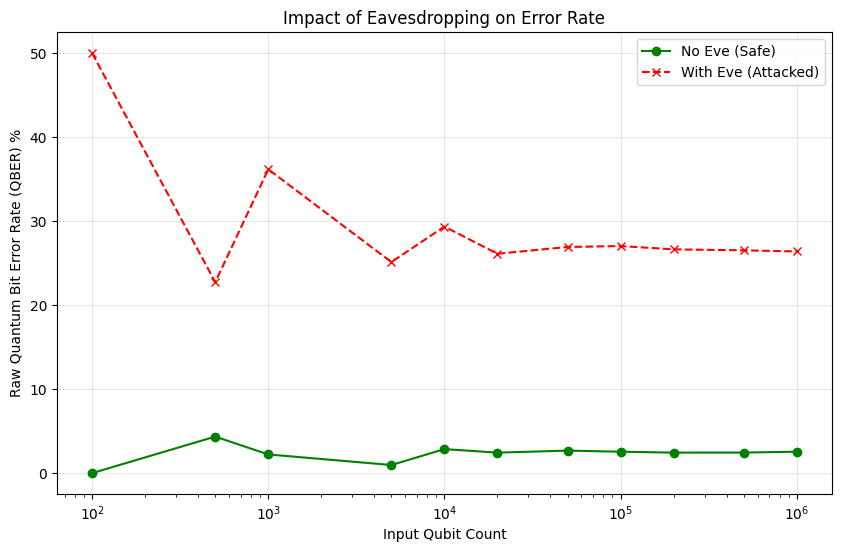

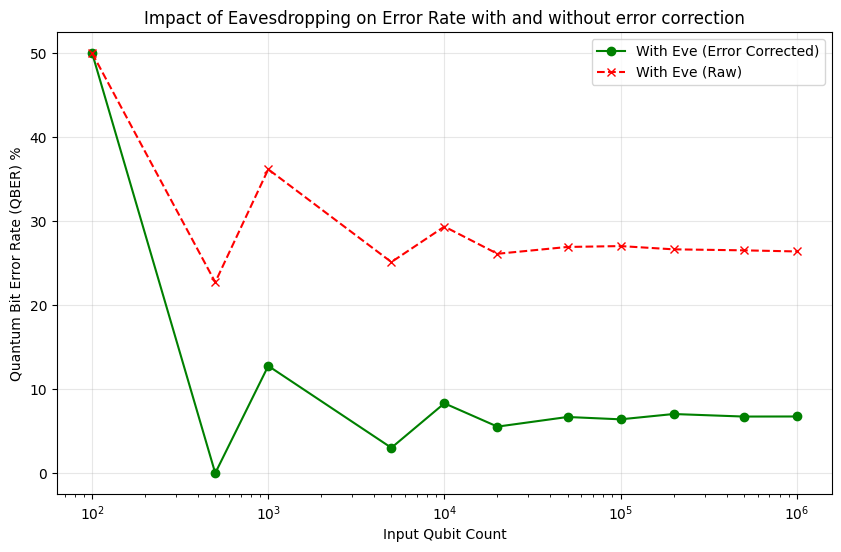

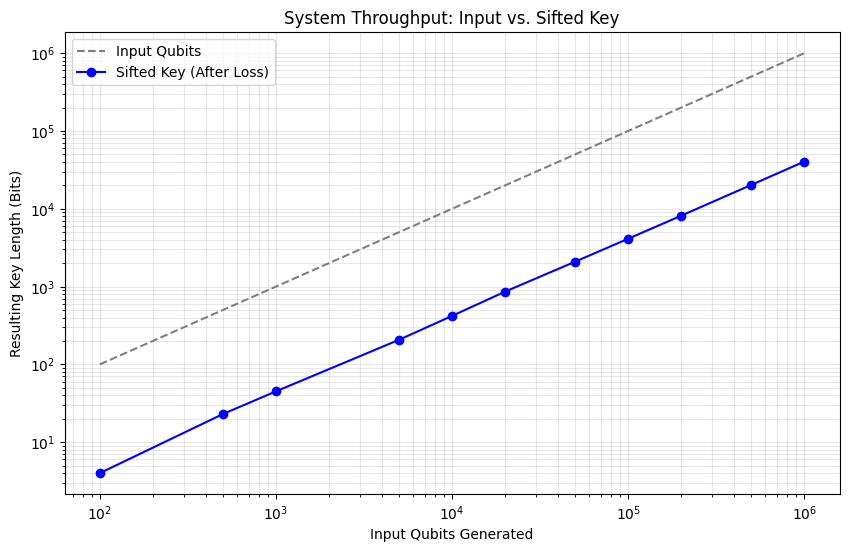

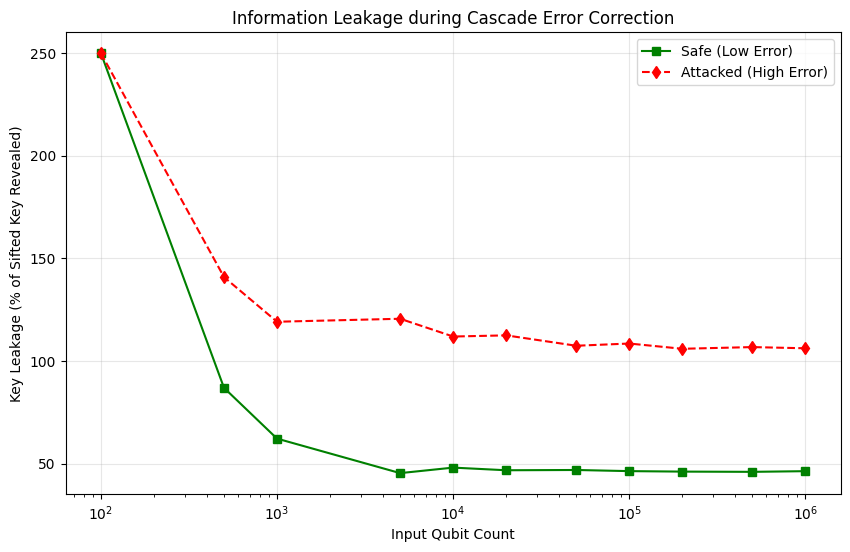


STARTING RECONCILIATION EFFICIENCY vs QBER EXPERIMENT
OpticalErr: 0.0120 | QBER: 0.0143 | Leaked: 129/420 | Eff: 2.8433
OpticalErr: 0.0145 | QBER: 0.0238 | Leaked: 141/420 | Eff: 2.0681
OpticalErr: 0.0169 | QBER: 0.0286 | Leaked: 147/420 | Eff: 1.8699
OpticalErr: 0.0194 | QBER: 0.0286 | Leaked: 147/420 | Eff: 1.8699
OpticalErr: 0.0219 | QBER: 0.0310 | Leaked: 150/420 | Eff: 1.7934
OpticalErr: 0.0243 | QBER: 0.0333 | Leaked: 155/420 | Eff: 1.7503
OpticalErr: 0.0268 | QBER: 0.0357 | Leaked: 158/420 | Eff: 1.6924
OpticalErr: 0.0293 | QBER: 0.0357 | Leaked: 158/420 | Eff: 1.6924
OpticalErr: 0.0317 | QBER: 0.0429 | Leaked: 169/420 | Eff: 1.5765
OpticalErr: 0.0342 | QBER: 0.0452 | Leaked: 172/420 | Eff: 1.5406
OpticalErr: 0.0367 | QBER: 0.0476 | Leaked: 175/420 | Eff: 1.5086
OpticalErr: 0.0391 | QBER: 0.0476 | Leaked: 175/420 | Eff: 1.5086
OpticalErr: 0.0416 | QBER: 0.0500 | Leaked: 178/420 | Eff: 1.4798
OpticalErr: 0.0441 | QBER: 0.0524 | Leaked: 181/420 | Eff: 1.4538
OpticalErr: 0.0465 | 

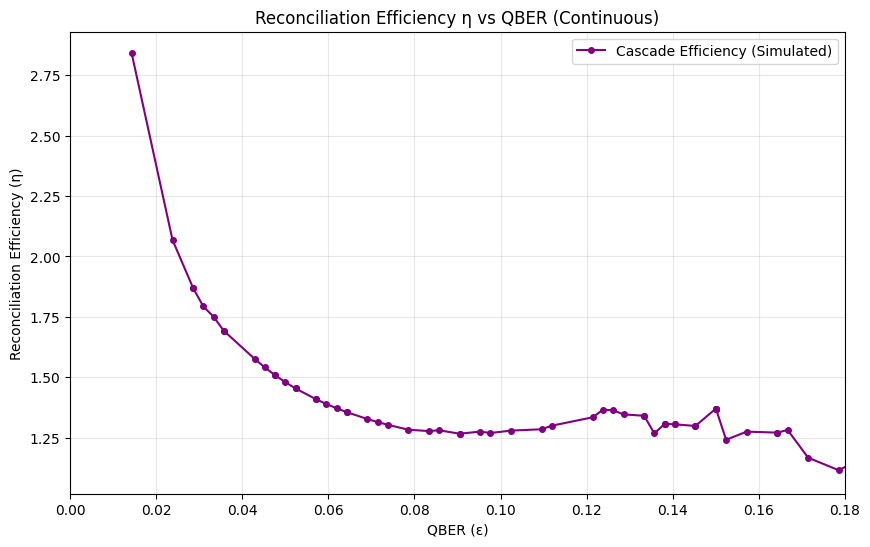


STARTING CHANNEL USES (ROUND-TRIP) EXPERIMENT

Running Scenario: Low Error (2%)
  Input: 200 | Sifted Key: 7 | Channel Uses: 4
  Input: 500 | Sifted Key: 23 | Channel Uses: 7
  Input: 1000 | Sifted Key: 45 | Channel Uses: 7
  Input: 2000 | Sifted Key: 83 | Channel Uses: 7
  Input: 5000 | Sifted Key: 207 | Channel Uses: 10
  Input: 10000 | Sifted Key: 420 | Channel Uses: 40
  Input: 20000 | Sifted Key: 861 | Channel Uses: 67
  Input: 50000 | Sifted Key: 2090 | Channel Uses: 180
  Input: 100000 | Sifted Key: 4120 | Channel Uses: 339
  Input: 200000 | Sifted Key: 8152 | Channel Uses: 635

Running Scenario: High Error (8%)
  Input: 200 | Sifted Key: 7 | Channel Uses: 4
  Input: 500 | Sifted Key: 23 | Channel Uses: 14
  Input: 1000 | Sifted Key: 45 | Channel Uses: 13
  Input: 2000 | Sifted Key: 83 | Channel Uses: 24
  Input: 5000 | Sifted Key: 207 | Channel Uses: 50
  Input: 10000 | Sifted Key: 420 | Channel Uses: 126
  Input: 20000 | Sifted Key: 861 | Channel Uses: 274
  Input: 50000 | Si

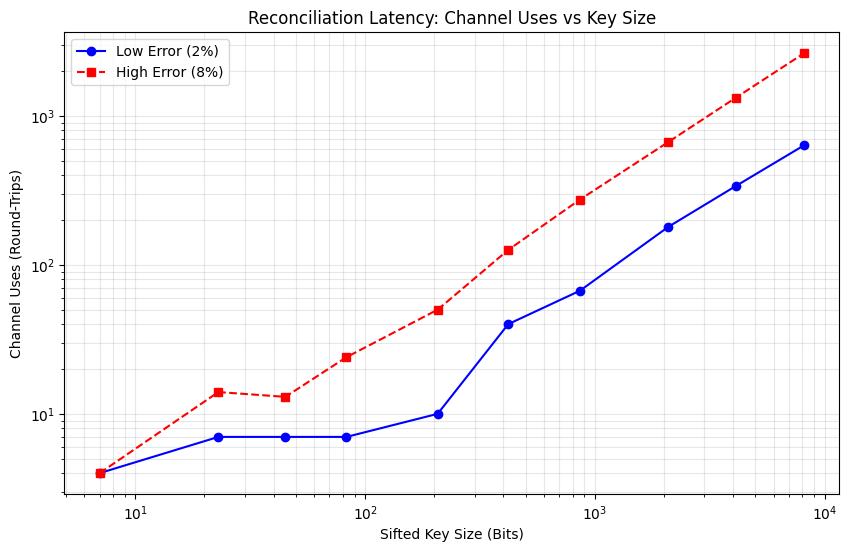

In [ ]:
# --- Main (Jupyter Notebook Version) ---

# 1. Run the detailed single instance log
print("Running Detailed Log Instance...")
cascade_single = Cascade(num_passes=4, initial_block_size=8)

# FIX: Use 'await' directly instead of 'asyncio.run()'
await run_simulation_instance(
    num_qubits=5000, 
    include_eve=True, 
    verbose=True, 
    error_correction=cascade_single
)

# 2. Run the original plotting experiment
# FIX: Use 'await' directly
await run_plotting_experiment()

# 3. Run the Efficiency experiment
# FIX: Use 'await' directly
await run_efficiency_experiment()

# 4. Run the NEW Channel Uses experiment
# FIX: Use 'await' directly
await run_channel_uses_experiment()